# Predicting ozone levels using Recurrent Neural Networks

Given a time series of various meteorological parameters such as N02 levels, wind speed & direction, temperature humidity etc, I will try to forecast the ozone levels. 

The data was recorded by air quality monitoring stations set up by the  Ministry of Ecology and Environment in China to monitor air pollutent concentrations. The data was given to me via personal communication with the author.  

## Data

- time series data in a csv file with approximately 50,000 points. 
- data sampled hourly. 


## Approach

- I will focus on predicting ozone using relative humidity (rh), 2 metre temperature (t2m), and boundary layer height (blh). 
- Supervised learning problem.
- Regression problem.
- Batch learning. 
- Metric = accuracy. 
- Will use a recurrent neural network to first predict the next hour or day ozone level and then may extend it to predicting a weeks ozone level. 
- I will give it information about the seasonality of the data.
    - Removing the seasonality may help performance as it wont have to learn it. 
    - Maybe ill remove it. 

## Assumptions

- The data hasnt been altered. 
- There are no external factors affecting the ozone levels which also do not affect the features used to predict the ozone levels. 
    - e.g. no anthropological effects. 
- Error of the measurement is minimal. 

## Use

- If the model could forecast the levels well, it may give some insight into the physical mechanisms at play? 
- Personally, it will be a learning experience in handling meteorological data and forecasting time series data. 
- The model could be used to inform peoples behaviour if they are told the polution levels in advance they can decide whether they want to spend much time outside or not. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotting import plot_history
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

import datetime

plt.style.use('ggplot')


Bad key "text.kerning_factor" on line 4 in
/Users/jamieward/.matplotlib/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "mathtext.fallback" on line 156 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 177 in
/Users/jamieward/.matplotlib/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df = pd.read_csv('1094A.csv', index_col=None)

In [3]:
df.head()

,time,blh,t2m,crr,lsrr,uvb,u10,v10,d2m,pev,...,NO2_pct_anom,hour_number,O3_data,O3_expected,O3_residual,O3_pct_anom,PM2.5_data,PM2.5_expected,PM2.5_residual,PM2.5_pct_anom
0,2015-01-01 08:00:00,30.503819,253.595233,0.0,0.0,0.000000,0.438134,0.644206,245.889635,-7.760101e-07,...,NaN,0,NaN,10.012619,NaN,NaN,NaN,54.654072,NaN,NaN
1,2015-01-01 09:00:00,50.755446,255.820408,0.0,0.0,18165.665221,0.720263,0.781736,247.365563,-2.524582e-06,...,NaN,1,NaN,11.104024,NaN,NaN,NaN,66.484502,NaN,NaN
2,2015-01-01 10:00:00,239.716325,261.780507,0.0,0.0,62852.706436,1.163587,1.674938,247.820755,-2.500688e-05,...,NaN,2,NaN,16.312209,NaN,NaN,NaN,87.107951,NaN,NaN
3,2015-01-01 11:00:00,357.252692,261.317850,0.0,0.0,111279.727163,2.000161,2.432853,247.485147,-5.952067e-05,...,NaN,3,NaN,23.926343,NaN,NaN,NaN,76.203176,NaN,NaN
4,2015-01-01 12:00:00,472.659021,261.192680,0.0,0.0,146885.591929,2.805879,2.834125,247.357875,-9.160825e-05,...,NaN,4,NaN,33.377898,NaN,NaN,NaN,71.227592,NaN,NaN


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
blh,50400.0,585.716407,749.946903,1.217110e+01,53.094928,231.008294,854.046354,4929.904808
t2m,50400.0,279.893605,12.941981,2.452342e+02,269.056716,281.608103,290.854709,307.776909
crr,50400.0,0.000006,0.000061,-4.656613e-10,0.000000,0.000000,0.000000,0.004291
lsrr,50400.0,0.000007,0.000059,-4.656613e-10,0.000000,0.000000,0.000000,0.003786
uvb,50400.0,74717.189037,103585.832500,-1.562500e-02,0.000000,5165.956288,138225.984032,389533.643159
u10,50400.0,0.584603,1.827139,-6.657851e+00,-0.720044,0.322444,1.714213,9.422509
v10,50400.0,-0.167779,2.179539,-9.953152e+00,-1.494962,-0.080784,1.355793,9.781671
d2m,50400.0,268.581836,12.754774,2.357340e+02,257.454910,268.604224,279.739063,294.561741
pev,50400.0,-0.000123,0.000184,-8.513211e-04,-0.000179,-0.000017,-0.000003,0.000012
wdir,50400.0,186.636572,107.855510,4.816765e-04,89.096919,203.063822,276.456133,359.999694


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 26 columns):
time              50400 non-null object
blh               50400 non-null float64
t2m               50400 non-null float64
crr               50400 non-null float64
lsrr              50400 non-null float64
uvb               50400 non-null float64
u10               50400 non-null float64
v10               50400 non-null float64
d2m               50400 non-null float64
pev               50400 non-null float64
wdir              50400 non-null float64
wspd              50400 non-null float64
rh                50400 non-null float64
NO2_data          47713 non-null float64
NO2_expected      50400 non-null float64
NO2_residual      47713 non-null float64
NO2_pct_anom      47713 non-null float64
hour_number       50400 non-null int64
O3_data           46711 non-null float64
O3_expected       50400 non-null float64
O3_residual       46711 non-null float64
O3_pct_anom       46711 non-null 

In [6]:
## Fill the NaNs with interpolated data for O3
## for the sake of this example, I'll keep it simple
df = pd.read_csv('1094A.csv', index_col=None)
df['O3_data'].interpolate(inplace=True)
nulls = df['O3_data'].isnull()
np.where(nulls == True)[0].shape[0]

print(f"The first 17 rows have Nans, so I'm going to remove them!")
df = df.iloc[17:]


The first 17 rows have Nans, so I'm going to remove them!


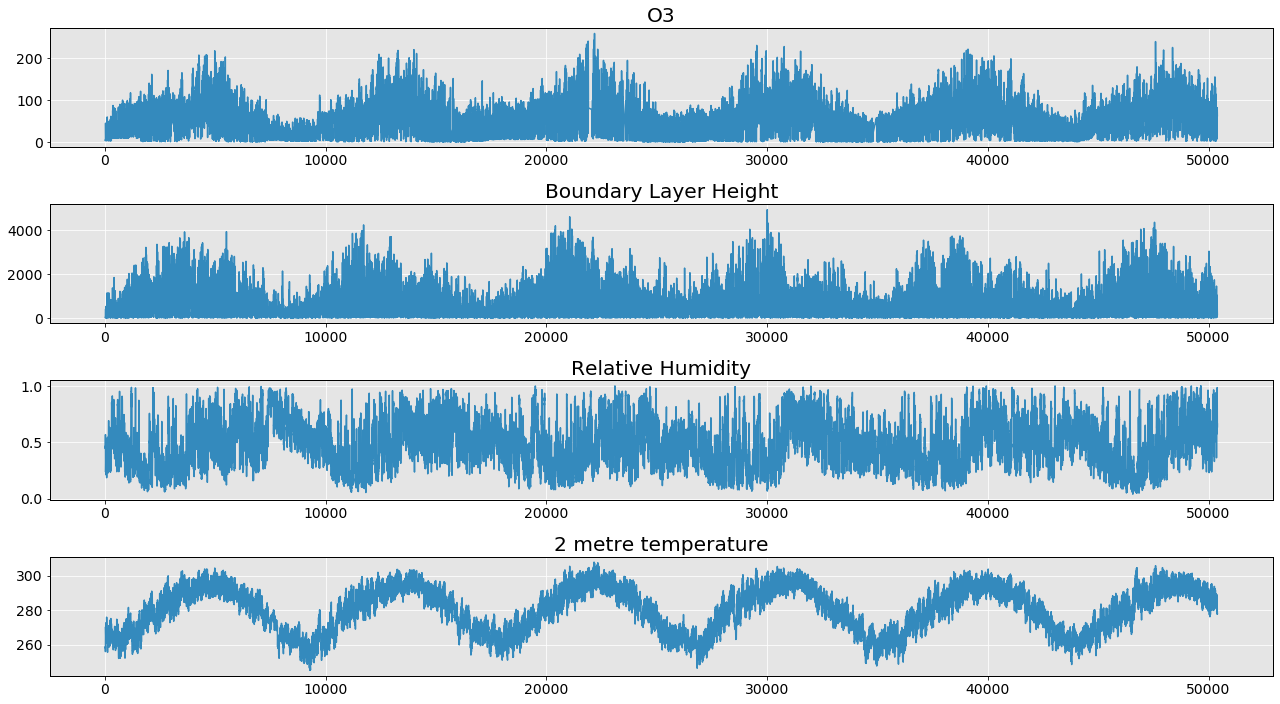

In [7]:
## plot data?

fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(411)
ax.plot(df['O3_data'])
ax.set_title("O3")

ax = fig.add_subplot(412)
ax.plot(df['blh'])
ax.set_title("Boundary Layer Height")

ax = fig.add_subplot(413)
ax.plot(df['rh'])
ax.set_title("Relative Humidity")

ax = fig.add_subplot(414)
ax.plot(df['t2m'])
ax.set_title("2 metre temperature")

plt.tight_layout()
plt.show()

In [8]:
date_time = pd.to_datetime(df.pop('time'), format='%Y-%m-%d %H:%M:%S')


In [9]:
# convert to seconds 
timestamp_s = date_time.map(datetime.datetime.timestamp)


2022-05-25 09:46:53.410498: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


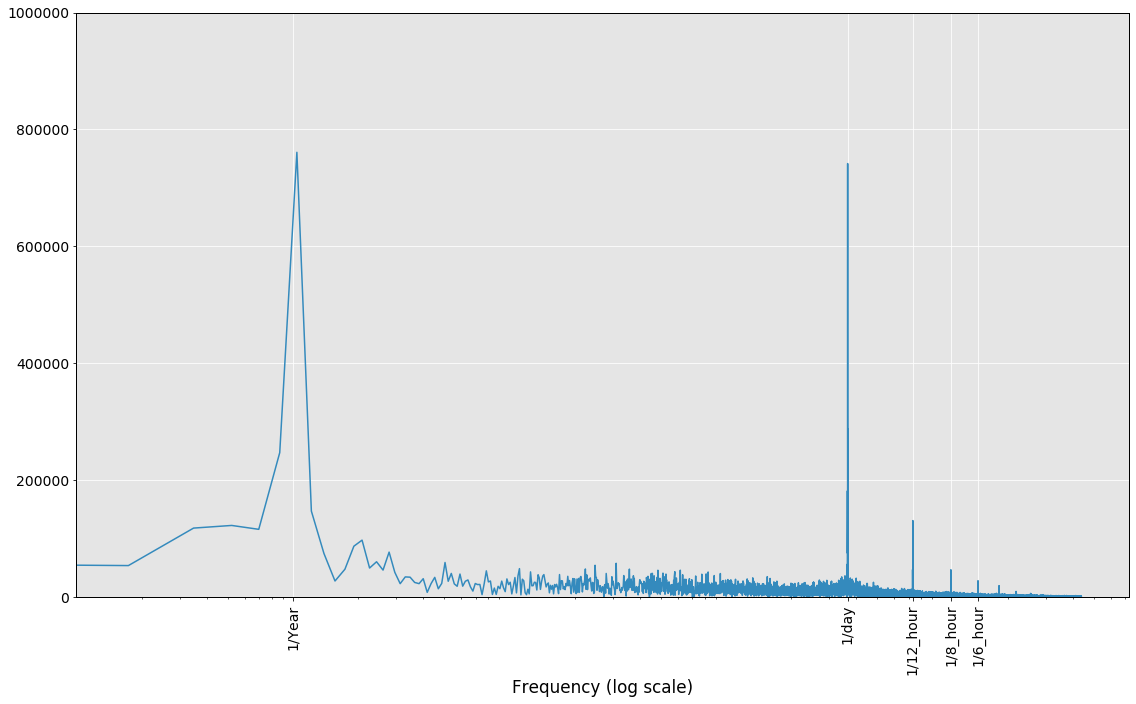

In [10]:
## take fourier transform of some of the data to see 
## if there are any patterns

fft = tf.signal.rfft(df['O3_data'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['O3_data'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset


fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)

ax1.plot(f_per_year, np.abs(fft))
ax1.set_xscale('log')
ax1.set_ylim(0, 1000000)
ax1.set_xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524, 365.2524*2, 365.2524*4, 365.2524*3], 
           labels=['1/Year', '1/day', '1/12_hour', '1/6_hour', '1/8_hour'], 
           rotation=90, horizontalalignment='center')
_ = ax1.set_xlabel('Frequency (log scale)')

plt.tight_layout()

In [11]:
## now also adding 12h and 8h 

day = 24*60*60
year = (365.2425)*day


h12 = 12*60*60
h8 = 8*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df['12h sin'] = np.sin(timestamp_s * (2 * np.pi / h12))
df['12h cos'] = np.cos(timestamp_s * (2 * np.pi / h12))
df['8h sin'] = np.sin(timestamp_s * (2 * np.pi / h8))
df['8h cos'] = np.cos(timestamp_s * (2 * np.pi / h8))






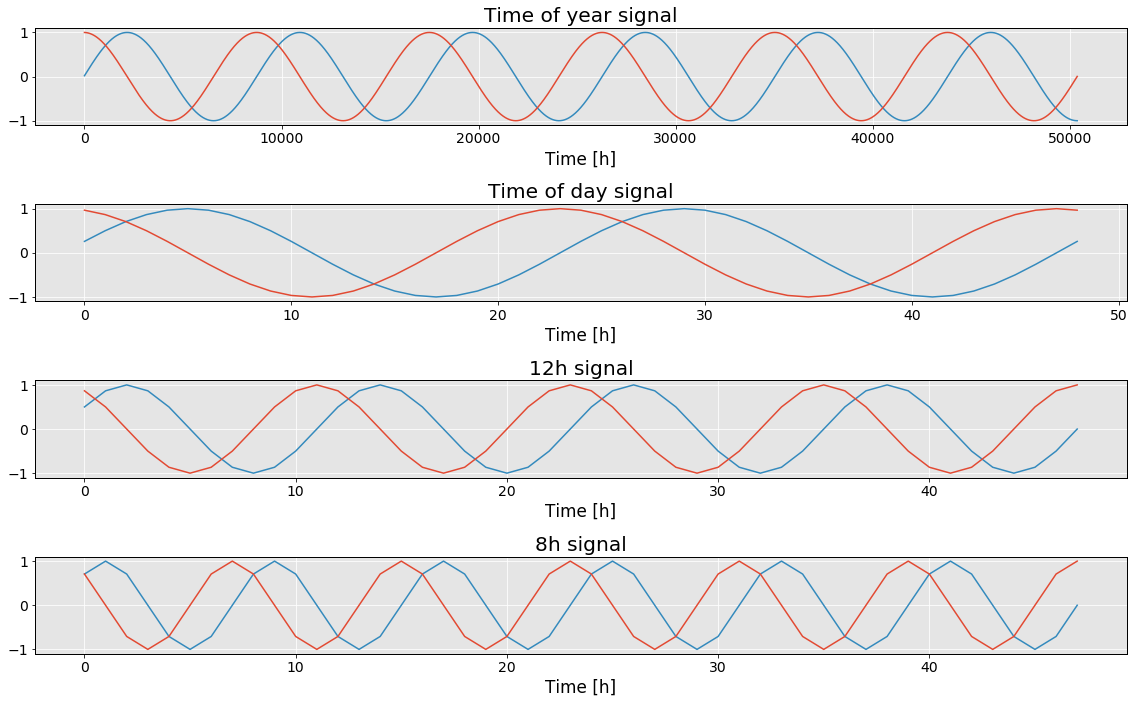

In [12]:
fig = plt.figure(figsize=(16,10))


ax1 = fig.add_subplot(411)
ax1.plot(np.array(df['Year sin'])[:])
ax1.plot(np.array(df['Year cos'])[:])
ax1.set_title('Time of year signal')
ax1.set_xlabel('Time [h]')

ax2 = fig.add_subplot(412)
ax2.plot(np.array(df['Day sin'])[:49])
ax2.plot(np.array(df['Day cos'])[:49])
ax2.set_title('Time of day signal')
ax2.set_xlabel('Time [h]')

ax1 = fig.add_subplot(413)
ax1.plot(np.array(df['12h sin'])[:48])
ax1.plot(np.array(df['12h cos'])[:48])
ax1.set_title('12h signal')
ax1.set_xlabel('Time [h]')

ax2 = fig.add_subplot(414)
ax2.plot(np.array(df['8h sin'])[:48])
ax2.plot(np.array(df['8h cos'])[:48])
ax2.set_title('8h signal')
ax2.set_xlabel('Time [h]')



plt.tight_layout()

In [13]:
## split the data into training and test data sets
ax.plot(df['O3_data'])
ax.plot(df['blh'])
ax.plot(df['rh'])
ax.plot(df['t2m'])

ax1.plot(np.array(df['Year sin'])[:])
ax1.plot(np.array(df['Year cos'])[:])

ax2.plot(np.array(df['Day sin'])[:49])
ax2.plot(np.array(df['Day cos'])[:49])

ax1.plot(np.array(df['12h sin'])[:48])
ax1.plot(np.array(df['12h cos'])[:48])

ax2.plot(np.array(df['8h sin'])[:48])
ax2.plot(np.array(df['8h cos'])[:48])

X = df[['blh', 'rh', 't2m', 'Year sin','Year cos','Day sin','Day cos',
        '12h sin','12h cos','8h sin','8h cos', 'O3_data']].copy()
# Y = df['O3_data'].copy()

In [14]:
# 2019 
test_time = date_time[-15344:-6583]
X_test = X[-15344:-6583]
# Y_test = Y[-15344:-6583]

# 2015 - 2018
train_time = date_time[:26280]
X_train = X[:26280]
# Y_train = X[:26280]

# 2018-2019
valid_time = date_time[26280:-15344]
X_valid = X[26280:-15344]
# Y_valid = X[26280:-15344]

# 2020
covid_time = date_time[-6583:]
X_covid = X[-6583:]
# Y_covid = X[-6583:]

In [15]:
X_train

,blh,rh,t2m,Year sin,Year cos,Day sin,Day cos,12h sin,12h cos,8h sin,8h cos,O3_data
17,35.400952,0.462863,258.355935,0.019424,0.999811,2.588190e-01,0.965926,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01,4.580537
18,30.308304,0.458157,258.445776,0.020140,0.999797,5.000000e-01,0.866025,8.660254e-01,5.000000e-01,1.000000e+00,1.507449e-11,4.580537
19,26.579387,0.443242,258.963516,0.020857,0.999782,7.071068e-01,0.707107,1.000000e+00,2.060538e-11,7.071068e-01,-7.071068e-01,3.664430
20,23.782132,0.475352,257.909805,0.021573,0.999767,8.660254e-01,0.500000,8.660254e-01,-5.000000e-01,1.763783e-11,-1.000000e+00,3.664430
21,20.798622,0.482587,257.807603,0.022290,0.999752,9.659258e-01,0.258819,5.000000e-01,-8.660254e-01,-7.071068e-01,-7.071068e-01,3.664430
...,...,...,...,...,...,...,...,...,...,...,...,...
26292,19.356244,0.328450,263.628456,0.003326,0.999994,-8.660254e-01,0.500000,-8.660254e-01,-5.000000e-01,-1.250906e-11,-1.000000e+00,2.748322
26293,16.405355,0.330435,263.443020,0.004043,0.999992,-7.071068e-01,0.707107,-1.000000e+00,-2.216350e-12,-7.071068e-01,-7.071068e-01,1.832215
26294,17.315961,0.364176,262.102226,0.004759,0.999989,-5.000000e-01,0.866025,-8.660254e-01,5.000000e-01,-1.000000e+00,9.945718e-12,2.748322
26295,18.638178,0.402880,260.702900,0.005476,0.999985,-2.588190e-01,0.965926,-5.000000e-01,8.660254e-01,-7.071068e-01,7.071068e-01,0.916107


In [16]:
## Normalise the data 
# only use the training mean and std
# so the model has no hints in the valid and test set
train_mean = X_train.mean()
train_std = X_train.std()

X_train_norm = (X_train - train_mean) / train_std
X_valid_norm = (X_valid - train_mean) / train_std
X_test_norm = (X_test - train_mean) / train_std

In [17]:
Y_train = X_train_norm['O3_data']
Y_valid = X_valid_norm['O3_data']
Y_test = X_test_norm['O3_data']

In [18]:
# convert to tensor dataset
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm.values))
X_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_norm.values))
X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm.values))

X_train_dataset

<TensorSliceDataset shapes: (12,), types: tf.float64>

## Attempt 1 - Predict an hour with previous day of data

In [19]:
# window the data

# sampling rate = 1h
day = 24
year = 365
month = day * 31
week = day * 7
hour = 1

window_length=day

windows_train = X_train_dataset.window(window_length, shift=1, drop_remainder=True)
windows_valid = X_valid_dataset.window(window_length, shift=1, drop_remainder=True)
windows_test = X_test_dataset.window(window_length, shift=1, drop_remainder=True)

In [20]:
windows_train.element_spec

DatasetSpec(TensorSpec(shape=(12,), dtype=tf.float64, name=None), TensorShape([]))

In [21]:
# convert to a flat dataset

windows_train = windows_train.flat_map(lambda window: window.batch(24))
windows_valid = windows_valid.flat_map(lambda window: window.batch(24))
windows_test = windows_test.flat_map(lambda window: window.batch(24))

In [22]:
windows_train.element_spec

TensorSpec(shape=(None, 12), dtype=tf.float64, name=None)

In [23]:
# shuffle the windows and make them into batches
batch_size = 64
windows_train = windows_train.shuffle(10000).batch(batch_size)
windows_valid = windows_valid.shuffle(10000).batch(batch_size)
windows_test = windows_test.batch(batch_size)


In [24]:
windows_train = windows_train.map(lambda windows: (windows[:, :-1], windows[:, -1:][:,-1,-1]))
windows_valid = windows_valid.map(lambda windows: (windows[:, :-1], windows[:, -1:][:,-1,-1]))
windows_test = windows_test.map(lambda windows: (windows[:, :-1], windows[:, -1:][:,-1,-1]))


In [25]:
for window in windows_train:
    print(window)

2022-05-25 09:46:57.481894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(<tf.Tensor: shape=(64, 23, 12), dtype=float64, numpy=
array([[[ 2.93612402e+00, -1.98714143e+00,  1.23048878e+00, ...,
         -9.99980974e-01, -9.99980974e-01,  1.47943170e+00],
        [ 3.06428830e+00, -1.99771693e+00,  1.23656329e+00, ...,
         -1.41418666e+00, -1.96272387e-11,  1.52164263e+00],
        [ 2.90996165e+00, -1.98239640e+00,  1.22625406e+00, ...,
         -9.99980974e-01,  9.99980974e-01,  1.56385356e+00],
        ...,
        [-4.34605647e-02, -1.16216094e+00,  9.59672323e-01, ...,
          9.99980974e-01,  9.99980974e-01,  7.19634940e-01],
        [ 2.97653046e-01, -1.08914570e+00,  9.47842462e-01, ...,
          1.41418666e+00, -2.64083857e-11,  9.51795061e-01],
        [ 1.16916383e+00, -1.08533689e+00,  9.68502744e-01, ...,
          9.99980974e-01, -9.99980974e-01,  1.14174425e+00]],

       [[-6.54278762e-01,  1.74136907e+00, -1.10657391e+00, ...,
         -2.08114924e-11,  1.41418666e+00, -1.13764603e+00],
        [-5.87054307e-01,  1.71249837e+00, -1.12

In [26]:
## Baseline metric tests
model = keras.models.Sequential([
    keras.layers.Dense(20),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20), 
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

# drop the target label
train_use = X_train_norm.drop(columns=['O3_data'])
valid_use = X_valid_norm.drop(columns=['O3_data'])
test_use = X_test_norm.drop(columns=['O3_data'])


model.compile(loss=keras.losses.mean_squared_error, optimizer="adam")

history = model.fit(train_use, Y_train, validation_data=(valid_use, Y_valid), epochs=20)


Epoch 1/20
822/822 [==============================] - 2s 2ms/step - loss: 0.6994 - val_loss: 0.4087
Epoch 2/20
822/822 [==============================] - 1s 2ms/step - loss: 0.4583 - val_loss: 0.4104
Epoch 3/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4323 - val_loss: 0.4025
Epoch 4/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4209 - val_loss: 0.4112
Epoch 5/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4181 - val_loss: 0.3964
Epoch 6/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4131 - val_loss: 0.4175
Epoch 7/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4122 - val_loss: 0.3968
Epoch 8/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4117 - val_loss: 0.4209
Epoch 9/20
822/822 [==============================] - 2s 2ms/step - loss: 0.4091 - val_loss: 0.3966
Epoch 10/20
822/822 [==============================] - 2s 3ms/step - loss: 0.4100 - val_loss: 0.4274

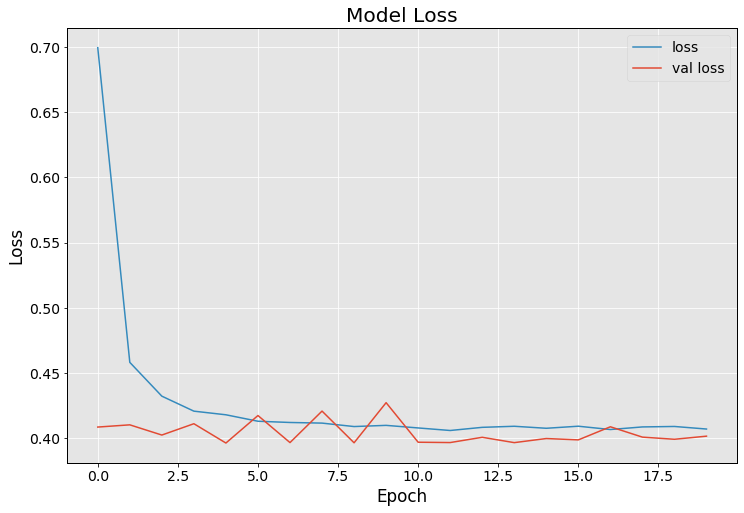

In [27]:
plot_history(history)

In [28]:
## calculate R^2 score

y_pred = model.predict(test_use)

print(r2_score(Y_test, y_pred))


0.6398812122897442


In [29]:
model_rnn = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 12],
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.LSTM(20, return_sequences=False,
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.Dense(1)
])

model.summary()

model_rnn.compile(loss=keras.losses.mean_squared_error, optimizer="adam")

history = model_rnn.fit(windows_train, validation_data=windows_valid, epochs=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                240       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
411/411 [==============================] - 28s 55ms/step - loss: 0.2470 - val_loss: 0.1202
Epoch 2/20
411/411 [==

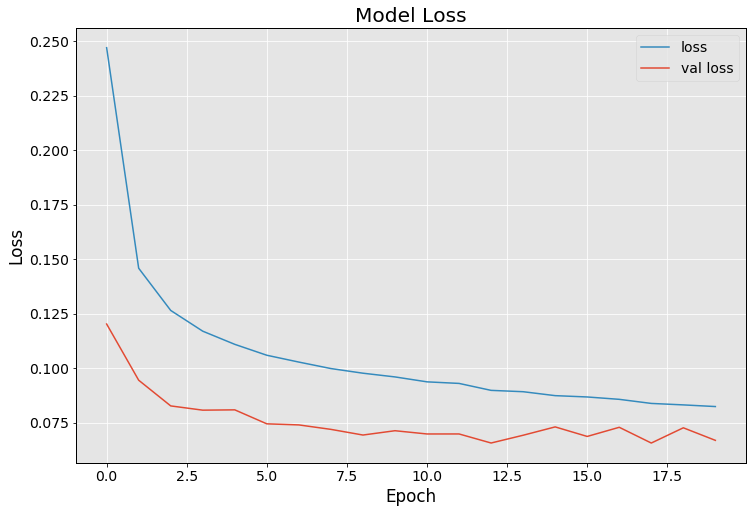

In [30]:
plot_history(history)

In [31]:
# get Y-true from the input datasets

y_true_test_rnn = []

count=0
for X,Y in windows_test:
    count += 1
    y_true_test_rnn.extend(list(Y.numpy()))
y_true_test_rnn = np.array(y_true_test_rnn)
    
y_pred = model_rnn.predict(windows_test)

print(y_pred.shape)
print(y_true_test_rnn.shape)

print(r2_score(y_true_test_rnn, y_pred.flatten()))


(8738, 1)
(8738,)
0.9344221346029818


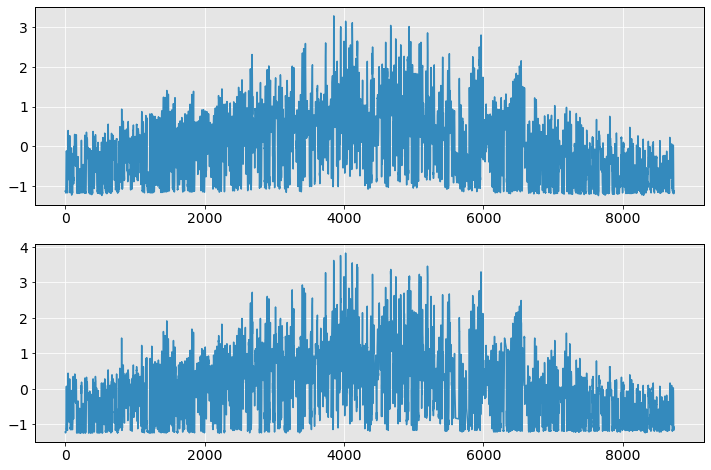

In [44]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.plot(y_pred)
ax2 = fig.add_subplot(212)
ax2.plot(y_true_test_rnn)



## Attempt 2 - Predict a day given the past week

- First using an RNN using the last hidden state of the previous time step. 
- Then using a sequence to sequence RNN. 
    - Note: Tried this but currently does not work as the labels are not time distributed. I am going to move on to other things and I dont want to spend time bogged down in trying to get the labels in the right format. 
    - Currently, the previous RNN works very well which is good enough for me :). 

In [45]:
day = 24
year = 365
month = day * 31
week = day * 7
hour = 1

window_length=day + week

windows_train_week = X_train_dataset.window(window_length, shift=day, drop_remainder=True)
windows_valid_week = X_valid_dataset.window(window_length, shift=day, drop_remainder=True)
windows_test_week = X_test_dataset.window(window_length, shift=day, drop_remainder=True)

In [46]:
windows_train_week = windows_train_week.flat_map(lambda w: w.batch(window_length))
windows_valid_week = windows_valid_week.flat_map(lambda w: w.batch(window_length))
windows_test_week = windows_test_week.flat_map(lambda w: w.batch(window_length))

In [47]:
# shuffle the windows and make them into batches
batch_size = 64
windows_train_week = windows_train_week.shuffle(10000).batch(batch_size)
windows_valid_week = windows_valid_week.shuffle(10000).batch(batch_size)
windows_test_week = windows_test_week.batch(batch_size)

In [48]:
windows_train_week = windows_train_week.map(lambda w: (w[:, :-24, :], w[:, -24:][:,-24:,-1:]))
windows_valid_week = windows_valid_week.map(lambda w: (w[:, :-24, :], w[:, -24:][:,-24:,-1:]))
windows_test_week = windows_test_week.map(lambda w: (w[:, :-24, :], w[:, -24:][:,-24:,-1:]))


In [49]:
for X,Y in windows_train_week:
    print(X)
    print(Y)

tf.Tensor(
[[[-7.17590611e-01 -1.03464843e+00  3.80359580e-01 ... -4.96961861e-12
    1.41418666e+00 -1.22206790e+00]
  [-7.21690201e-01 -1.11820842e+00  4.34635543e-01 ...  9.99980974e-01
    9.99980974e-01 -1.17985696e+00]
  [-7.14767842e-01 -1.03057581e+00  4.55106177e-01 ...  1.41418666e+00
    8.60704326e-12 -1.22206790e+00]
  ...
  [-6.32805627e-01 -1.38319850e+00  5.03292118e-02 ... -9.99980974e-01
   -9.99980974e-01  4.66369353e-01]
  [-6.73983726e-01 -1.15883481e+00 -1.48288557e-01 ... -1.41418666e+00
    2.34354864e-11  3.39736559e-01]
  [-7.15715675e-01 -1.16668545e+00 -1.41277525e-01 ... -9.99980974e-01
    9.99980974e-01  2.34209231e-01]]

 [[-7.50180951e-01  1.56111352e+00  1.48900793e-01 ... -1.76818319e-11
    1.41418666e+00 -1.24317336e+00]
  [-7.51674865e-01  1.52220440e+00  1.47357947e-01 ...  9.99980974e-01
    9.99980974e-01 -1.24317336e+00]
  [-7.51528264e-01  1.44664948e+00  1.46618201e-01 ...  1.41418666e+00
    2.13192566e-11 -1.24317336e+00]
  ...
  [-7.412506

In [50]:
# model_rnn_2 = keras.models.Sequential([
#     keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 12],
#                      dropout=0.2, recurrent_dropout=0.2), 
#     keras.layers.LSTM(20, return_sequences=True,
#                      dropout=0.2, recurrent_dropout=0.2), 
#     keras.layers.TimeDistributed(keras.layers.Dense(24))
# ])

model_rnn_2 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 12],
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.LSTM(20, return_sequences=False,
                     dropout=0.2, recurrent_dropout=0.2), 
    keras.layers.Dense(24)
])


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, :, -1], Y_pred[:, :, -1])

model_rnn_2.summary()

model_rnn_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam")

history = model_rnn_2.fit(windows_train_week, validation_data=windows_valid_week, epochs=20)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 20)          2640      
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                504       
Total params: 6,424
Trainable params: 6,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
17/17 [==============================] - 11s 327ms/step - loss: 0.9240 - val_loss: 0.8780
Epoch 2/20
17/17 [==============================] - 5s 300ms/step - loss: 0.7267 - val_loss: 0.6478
Epoch 3/20
17/17 [==============================] - 6s 326ms/step - loss: 0.5395 - val_loss: 0.4834
Epoch 4/20
17/17 [==============================] - 6s 320ms/step - loss: 0.4213 

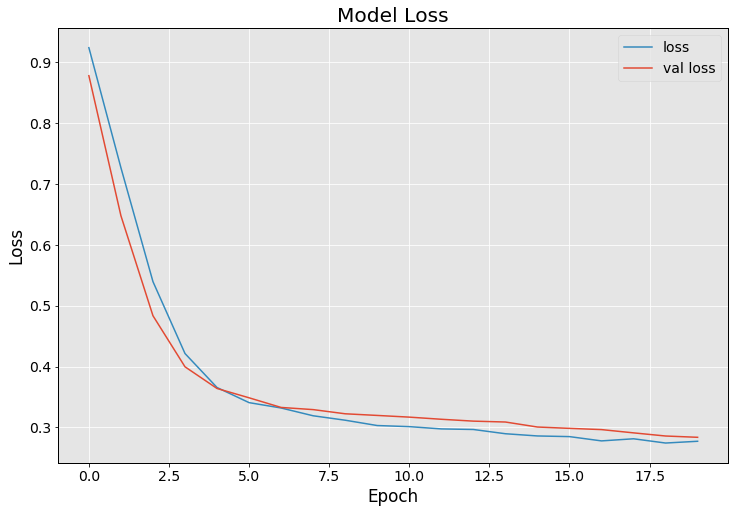

In [51]:
plot_history(history)

# Concluding thoughts

I have successfully trained two recurrent neural networks to forecast ozone. One will forecast the next hour using the past day and another to predict the next day using the past week of data. 